In [144]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

data_path = "C:/Users/mhals/Dropbox/PC (2)/Documents/GitHub/phys117/Markus/Pandas_analysis/Subplots/Hub/XGBoost/CSVData/"
data_files = [data_path + data_file for data_file in os.listdir(data_path)]
folders = ["Background", "BH", "Sphaleron"]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
file_amounts = [2, 18, 3]


folder_dataframes = []
for folder in folders:
    dataframes = []
    data_files = [data_path + folder + "/" + data_file for data_file in os.listdir(data_path + folder)]
    for data_file in data_files:
        data = pd.read_csv(data_file)
        data = data.drop("Unnamed: 0", axis = 1)
        dataframes.append(data)
    folder_dataframes.append(dataframes)

In [177]:
def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


all_or_subset = "subset"
if all_or_subset == "subset":
    # Selects a number of datasets from each folder
    from random import sample
    combined_dataframes = [pd.concat(sample(dataframes, 1)) for dataframes in folder_dataframes]
    unpacked_dataframes = unpacker(combined_dataframes, [])
    sample_num = np.min([len(dataframe.loc[:]) for dataframe in unpacked_dataframes])

    print(sample_num)
    combined_dataframes = [dataframes.sample(n = sample_num) for dataframes in combined_dataframes]

else:
    # Combines the dataframes from each folder
    combined_dataframes = [pd.concat(dataframes) for dataframes in folder_dataframes]
    unpacked_dataframes = unpacker(combined_dataframes, [])
    sample_num = np.min([len(dataframe.loc[:]) for dataframe in unpacked_dataframes])

    print(sample_num)
    combined_dataframes = [dataframes.sample(n = sample_num) for dataframes in combined_dataframes]


def input_data(event):
    pt_index = 3
    name_index = 0
    ptmax = sorted(event, key = lambda x: x[pt_index])[-1][pt_index]
    stuff_amount = len(event)
    met = [particle for particle in event if particle[name_index] == "MET"][0][pt_index]
    input_list = [ptmax, stuff_amount, met]
    
    return input_list


def dataframe_calc(dataframe):
    import ast
    dataframe = dataframe.drop("datasets", axis = 1)
    dataframe_dict = {}
    events = [row for row in dataframe.itertuples(index = False)]
    for event_index, event in enumerate(events):
        event = [tuple(ast.literal_eval(element)for element in particle.strip("()").split(", ")) for particle in event if "nan" not in particle]
        dataframe_dict[event_index] = input_data(event)
    input_variables = ["ptmax", "stuff_amount", "met"]
    data_df = list(dataframe_dict.values())
    dataframe = pd.DataFrame(data_df, columns = input_variables)
    return dataframe


datasets = pd.concat([dataframes["datasets"] for dataframes in combined_dataframes])
model_data = pd.concat([dataframe_calc(dataframes) for dataframes in combined_dataframes])

1000


In [178]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Data and real values being split
x = model_data
y = datasets
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


# Define the model and train it
xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 3)

# Bruk disse om det er 2 forskjellige type dataset, derfor "binary"
# xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
# xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 3)


# Train model on data
xgb_model.fit(x_train, y_train)

(3000, 3)
(3000,)
(2400, 3)
(600, 3)
(2400,)
(600,)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=22, reg_alpha=0, ...)

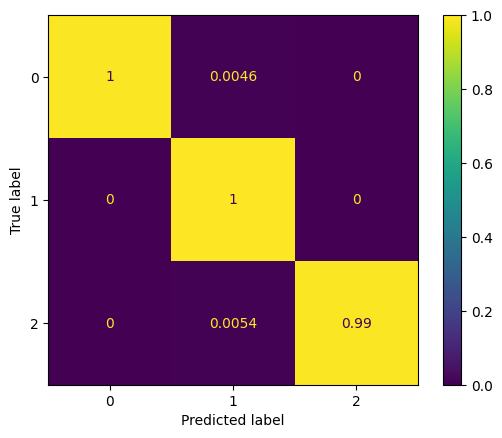

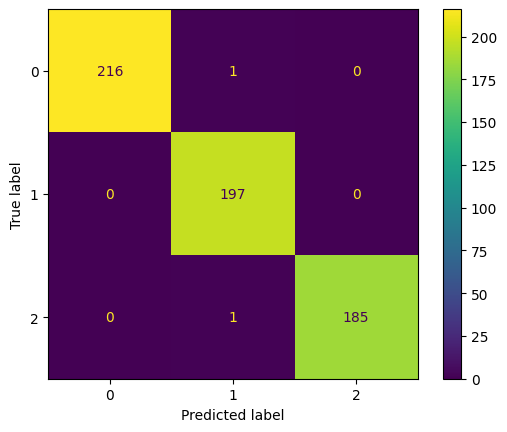

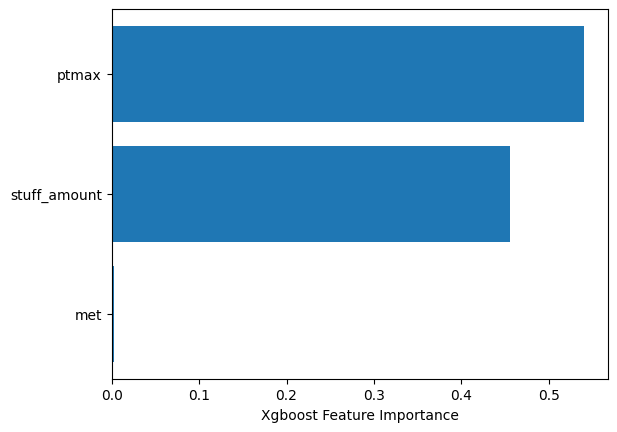

In [179]:
# Make predictions with model
y_pred = xgb_model.predict(x_test)


# Plot confusion matrix
conf = confusion_matrix(y_test, y_pred)
disp_norm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = conf)
disp.plot()
plt.show()


# Plot variables by importance for prediction
data_variables = ["ptmax", "stuff_amount", "met"]
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(np.array(data_variables)[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()